# Packages

In [1]:
import os
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import seaborn as sns
import tensorflow as tf
import xarray as xr
import xcube
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Input
from keras.models import Sequential
from keras.optimizers import Adam
from scalecast.Forecaster import Forecaster
from scalecast.SeriesTransformer import SeriesTransformer
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from xcube.core.store import new_data_store

2024-07-11 10:10:16.372046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 10:10:26.137642: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import lexcube

# Functions

In [3]:
def data_preprocess(df, variables, forest_vars):
    """
    Preprocesses the DataFrame by resetting index, sorting, removing NaNs, converting types, and normalizing.

    Parameters:
    df (DataFrame): Input DataFrame.
    variables (list of str): Columns to normalize and convert to float32.
    forest_vars (list of str): Columns to keep unscaled.

    Returns:
    DataFrame: Processed and normalized DataFrame.
    """
    df = df.reset_index(inplace=False)
    df = df.sort_values("time")
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df[variables] = df[variables].astype("float32")

    # Scale only the specified variables
    scaler_minmax = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler_minmax.fit_transform(df[variables])
    scaled_df = pd.DataFrame(scaled_data, columns=variables)

    # Combine scaled variables with unscaled forest variables and other columns
    all_data_scaled = scaled_df.copy()
    all_data_scaled[forest_vars] = df[forest_vars].values
    all_data_scaled["time"] = df["time"].values
    all_data_scaled["lat"] = df["lat"].values
    all_data_scaled["lon"] = df["lon"].values

    return all_data_scaled, scaler_minmax

In [4]:
def convert_to_matrix(data_arr, look_back, target_col):
    """
    Convert the dataset into input features and target variable with specified look-back period.

    Parameters:
    data_arr (np.array): Input dataset with features and target in the last column.
    look_back (int): Number of past observations each input sample should consist of.
    target_col (string): Name of target variabel column.
    exclude_cols (list): List of Strings containing the column names to be excluded.

    Returns:
    np.array, np.array: Arrays for input features (X) and target variable (Y).
    """
    data_arr_x = data_arr.drop(columns=target_col)
    data_arr_y = data_arr[target_col]

    X, Y = [], []

    for i in range(1, len(data_arr_x) - look_back):

        d = i + look_back

        x_seq = np.array(data_arr_x[i:d])

        y_shifted = np.array(data_arr_y[(i - 1) : (d - 1)]).reshape((-1, 1))

        assert x_seq.shape[0] == y_shifted.shape[0]

        x_sequence = np.hstack([x_seq, y_shifted])

        X.append(x_sequence)
        Y.append(data_arr_y.iloc[d - 1])

    return np.array(X), np.array(Y)

In [5]:
def split_data(df_scaled, lat, lon, look_back, target_col="sif_gosif"):
    """
    Splits the scaled DataFrame into training, validation, and test sets for a specified location and look-back period.
    The timeframes for splitting are partly overlapping as to model timestep t, the timesteps from t to t-lookback are neede

    Parameters:
    df_scaled (DataFrame): Preprocessed and scaled DataFrame.
    lat (float): Latitude to filter data.
    lon (float): Longitude to filter data.
    look_back (int): Number of past observations each input sample should consist of.

    Returns:
    tuple: Arrays of features and target variables for training, validation, and test datasets.
    """
    df_scaled = df_scaled.loc[(df_scaled["lat"] == lat) & (df_scaled["lon"] == lon)]

    train_data = df_scaled[df_scaled["time"].dt.year <= 2015]
    val_data = df_scaled[
        (df_scaled["time"].dt.year == 2016) | (df_scaled["time"].dt.year == 2017)
    ]
    test_data = df_scaled[(df_scaled["time"].dt.year >= 2018)]

    train = train_data.drop(columns=["time", "lat", "lon"])
    val = val_data.drop(columns=["time", "lat", "lon"])
    test = test_data.drop(columns=["time", "lat", "lon"])

    # Extend the validation and test sets by the look-back period to include necessary preceding time steps
    if not train_data.empty:
        val = pd.concat([train.iloc[-(look_back):], val])
    if not val_data.empty:
        test = pd.concat([val.iloc[-(look_back):], test])

    trainX, trainY = convert_to_matrix(train, look_back, target_col)
    valX, valY = convert_to_matrix(val, look_back, target_col)
    testX, testY = convert_to_matrix(test, look_back, target_col)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
    valX = np.reshape(valX, (valX.shape[0], valX.shape[1], valX.shape[2]))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

    test_index = sorted(list(set(test_data.time)))

    return trainX, trainY, valX, valY, testX, testY, test_index

In [6]:
def improved_model_lstm(look_back, features, learning_rate=0.001):
    """
    Constructs an LSTM model with dropout for regularization.

    Parameters:
    look_back (int): Number of time steps each input sequence contains.
    features (int): Number of input features per time step.
    learning_rate (float): Learning rate for the Adam optimizer.

    Returns:
    keras.Model: A compiled LSTM model with specified architecture and loss function.
    """
    model = Sequential()
    model.add(LSTM(128, input_shape=(look_back, features), activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(64))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        loss="mean_squared_error", optimizer=optimizer, metrics=["mse", "mae"]
    )
    return model


def model_lstm(look_back, features):
    """
    Defines a simpler LSTM model for regression tasks.

    Parameters:
    look_back (int): Number of time steps in the input data.
    features (int): Number of features in the input data.

    Returns:
    keras.Model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(128, input_shape=(look_back, features), activation="relu"))
    model.add(Dense(64))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

In [7]:
def run_model(
    trainX,
    trainY,
    valX,
    valY,
    look_back,
    epochs,
    learning_rate=0.001,
    batch_size=32,
    verbose=1,
):
    """
    Trains an LSTM model using provided training and validation data.

    Parameters:
    trainX (array): Input features for training.
    trainY (array): Target output for training.
    valX (array): Input features for validation.
    valY (array): Target output for validation.
    look_back (int): Number of time steps to consider for each input sequence.
    epochs (int): Number of epochs for training the model.
    learning_rate (float): Learning rate for the optimizer.
    batch_size (int): Number of samples per batch.
    verbose (int): Verbosity mode.

    Returns:
    tuple: Returns the trained model and the history object containing training details.
    """
    num_features = trainX.shape[2]
    model = improved_model_lstm(look_back, num_features, learning_rate)
    history = model.fit(
        trainX,
        trainY,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(valX, valY),
        callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
        verbose=verbose,
        shuffle=False,
    )
    return model, history

In [8]:
def plot_training(history):
    """
    Plots the training and validation loss and metrics from the training history.

    Parameters:
    history (History): History object from Keras training session.

    Returns:
    None
    """
    plt.figure(figsize=(14, 7))
    plt.plot(history.history["mse"], label="Train MSE")
    plt.plot(history.history["val_mse"], label="Validation MSE")
    plt.plot(history.history["mae"], label="Train MAE")
    plt.plot(history.history["val_mae"], label="Validation MAE")
    plt.title("Model Loss and Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / Metric")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

In [9]:
# Iterative prediction and substitution
def predict_replace(model, X_test):
    """
    Generates predictions and updates the test set input for iterative forecasting.

    Parameters:
    model (keras.Model): Trained LSTM model.
    X_test (array): Test data to predict.

    Returns:
    np.array: Array of forecasted values.
    """
    forecasts = []
    for i in range(len(X_test)):
        forecast = model.predict(X_test[i].reshape(1, look_back, -1), verbose=0)
        forecasts.append(forecast[0][0])
        if i < len(X_test) - 1:
            X_test[i + 1, :-1, -1] = X_test[i + 1, 1:, -1]
            X_test[i + 1, -1, -1] = forecast[0][0]
    forecasts_array = np.array(forecasts)
    return forecasts_array

In [10]:
# Evaluation function for model performance
def evaluate_model(true_values, predicted_values, data_type="Validation"):
    # Remove NaN values
    mask = ~np.isnan(predicted_values)

    true_values = true_values[mask]
    predicted_values = predicted_values[mask]

    if len(true_values) > 0 and len(predicted_values) > 0:
        rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
        mae = mean_absolute_error(true_values, predicted_values)
        print(f"{data_type} Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"{data_type} Mean Absolute Error (MAE): {mae:.2f}")
    else:
        print(f"{data_type} evaluation skipped due to insufficient data.")

    return rmse, mae

In [11]:
# Function to plot predicted vs. actual values
def plot_predicted_vs_actual(testY, forecasts, test_index, look_back):
    plt.figure(figsize=(14, 7))
    plt.plot(sorted(test_index[look_back + 1 :]), testY, label="Actual")
    plt.plot(sorted(test_index[look_back + 1 :]), forecasts, label="Predicted")
    plt.title("Actual vs Predicted Values")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Data

### Read Germany border

In [12]:
# Read
germany_shp_path = "data/germany_border.shp"
germany_gpd = gpd.read_file(germany_shp_path)

### Load and subset cube

In [13]:
cube_ger_path = os.path.join("data", "processed", "cube_preprocessed.nc")
cube_ger = xr.open_dataset(cube_ger_path, chunks={"time": 92, "lat": -1, "lon": -1})
cube_ger

<xarray.Dataset> Size: 46MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
Data variables:
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    min_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    deciduous               (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    coniferous              (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    mixed                   (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    all_classes             (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

# Lex

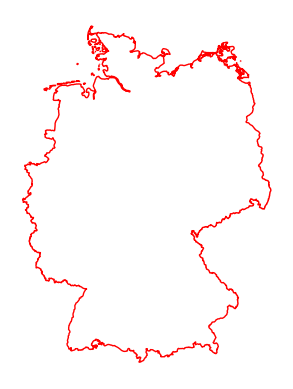

In [14]:
# Create a plot
fig, ax = plt.subplots()

# Plot the border with specified colors
germany_gpd.plot(ax=ax, edgecolor="red", facecolor="none")

# Remove axis
ax.axis("off")
plt.savefig(
    "output/germany_border.png", bbox_inches="tight", pad_inches=0, transparent=True
)

In [15]:
cube_ger

<xarray.Dataset> Size: 46MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
Data variables:
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    min_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    deciduous               (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    coniferous              (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    mixed                   (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
    all_classes             (time, lat, lon) float32 4MB dask.array<chunksize=(92, 31, 37), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [16]:
np.nanmax(cube_ger.evaporation_era5)

0.71113884

In [17]:
cube_ger.rio.write_crs(4326, inplace=True)
cube_ger = cube_ger.rio.clip(
    germany_gpd.geometry.values, germany_gpd.crs, drop=False, all_touched=False
)

In [18]:
w = lexcube.Cube3DWidget(
    cube_ger.radiation_era5, cmap="viridis", vmin=0, vmax=1006265
)  #
w

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

In [19]:
wa = lexcube.Cube3DWidget(
    cube_ger.radiation_era5, cmap="inferno", vmin=0, vmax=1006265.8
)  #
wa

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

In [20]:
c = lexcube.Cube3DWidget(cube_ger.precipitation_era5, cmap="YlGnBu", vmin=0, vmax=20)  #
c

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

In [21]:
d = lexcube.Cube3DWidget(
    cube_ger.air_temperature_2m, cmap="cividis", vmin=0, vmax=25
)  #
d

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

In [22]:
w = lexcube.Cube3DWidget(
    cube_ger.air_temperature_2m, cmap="bamako_r", vmin=0, vmax=0.7
)  #
w

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

In [23]:
os.getcwd()

'/home/imkeott/team-extra/imke&luis&moritz'

In [24]:
w.savefig(fname="sif_cube.png", include_ui=False, dpi_scale=2.0)

'When using Lexcube-generated images, please acknowledge/cite: M. Söchting, M. D. Mahecha, D. Montero and G. Scheuermann, "Lexcube: Interactive Visualization of Large Earth System Data Cubes," in IEEE Computer Graphics and Applications, vol. 44, no. 1, pp. 25-37, Jan.-Feb. 2024, doi: https://www.doi.org/10.1109/MCG.2023.3321989.'

### Mask Cube only keeping cells with 50% forest cover in 2002

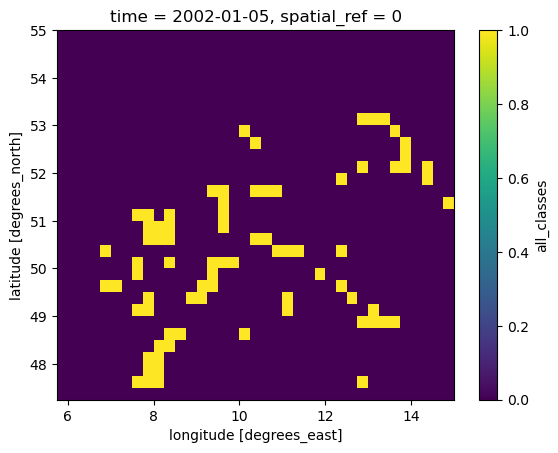

In [25]:
forest_2000_mask = (cube_ger.all_classes.isel(time=0) > 50).astype(int)
forest_2000_mask.plot()

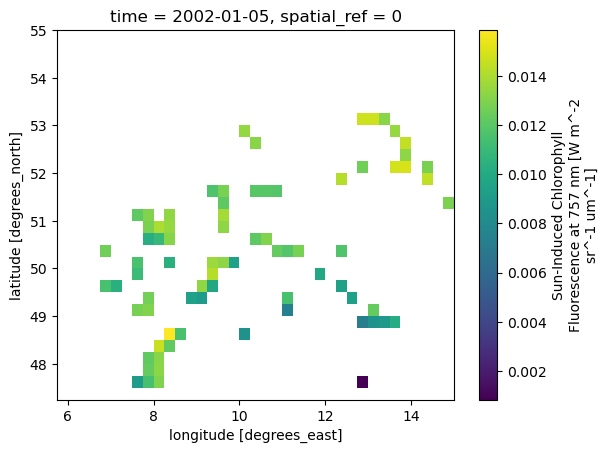

In [26]:
cube_ger_f = cube_ger.where(forest_2000_mask)
cube_ger_f.sif_gosif.isel(time=0).plot()

<Axes: title={'center': 'time = 2002-01-05, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

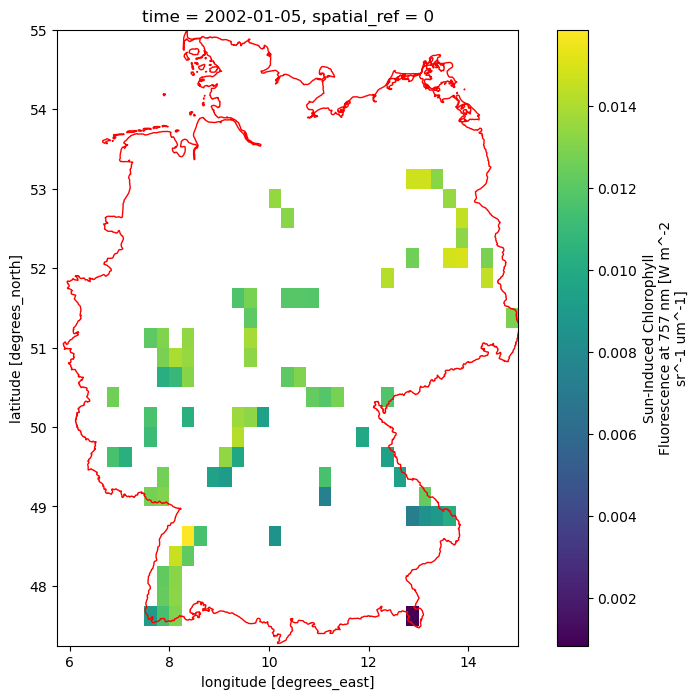

In [27]:
cube_ger_f.rio.write_crs(4326, inplace=True)
cube_ger_f_crop = cube_ger_f.rio.clip(
    germany_gpd.geometry.values, germany_gpd.crs, drop=False, all_touched=False
)

fig, ax = plt.subplots(figsize=(10, 8))
cube_ger_f_crop.sif_gosif.isel(time=0).plot(ax=ax)
germany_gpd.plot(ax=ax, edgecolor="red", facecolor="none")  # Adjust colors as needed

### Preprocessing Data

In [28]:
variables = [
    "sif_gosif",
    "evaporation_era5",
    "precipitation_era5",
    "radiation_era5",
    "air_temperature_2m",
    "max_air_temperature_2m",
    "min_air_temperature_2m",
]

In [29]:
all_data_df = cube_ger_f_crop.to_dataframe()
all_data_df

spatial_ref  evaporation_era5  precipitation_era5  \
lat    lon    time                                                            
47.375 5.875  2002-01-05            0               NaN                 NaN   
              2002-01-13            0               NaN                 NaN   
              2002-01-21            0               NaN                 NaN   
              2002-01-29            0               NaN                 NaN   
              2002-02-06            0               NaN                 NaN   
...                               ...               ...                 ...   
54.875 14.875 2021-11-29            0               NaN                 NaN   
              2021-12-07            0               NaN                 NaN   
              2021-12-15            0               NaN                 NaN   
              2021-12-23            0               NaN                 NaN   
              2021-12-31            0               NaN                 NaN   

                          radiation_era5  air_temperature_2m  \
lat    lon    time                                             
47.375 5.875  2002-01-05             NaN                 NaN   
              2002-01-13             NaN                 NaN   
              2002-01-21             NaN                 NaN   
              2002-01-29             NaN                 NaN   
              2002-02-06             NaN                 NaN   
...                                  ...                 ...   
54.875 14.875 2021-11-29             NaN                 NaN   
              2021-12-07             NaN                 NaN   
              2021-12-15             NaN                 NaN   
              2021-12-23             NaN                 NaN   
              2021-12-31             NaN                 NaN   

                          max_air_temperature_2m  min_air_temperature_2m  \
lat    lon    time                                                         
47.375 5.875  2002-01-05                     NaN                     NaN   
              2002-01-13                     NaN                     NaN   
              2002-01-21                     NaN                     NaN   
              2002-01-29                     NaN                     NaN   
              2002-02-06                     NaN                     NaN   
...                                          ...                     ...   
54.875 14.875 2021-11-29                     NaN                     NaN   
              2021-12-07                     NaN                     NaN   
              2021-12-15                     NaN                     NaN   
              2021-12-23                     NaN                     NaN   
              2021-12-31                     NaN                     NaN   

                          sif_gosif  deciduous  coniferous  mixed  all_classes  
lat    lon    time                                                              
47.375 5.875  2002-01-05        NaN        NaN         NaN    NaN          NaN  
              2002-01-13        NaN        NaN         NaN    NaN          NaN  
              2002-01-21        NaN        NaN         NaN    NaN          NaN  
              2002-01-29        NaN        NaN         NaN    NaN          NaN  
              2002-02-06        NaN        NaN         NaN    NaN          NaN  
...                             ...        ...         ...    ...          ...  
54.875 14.875 2021-11-29        NaN        NaN         NaN    NaN          NaN  
              2021-12-07        NaN        NaN         NaN    NaN          NaN  
              2021-12-15        NaN        NaN         NaN    NaN          NaN  
              2021-12-23        NaN        NaN         NaN    NaN          NaN  
              2021-12-31        NaN        NaN         NaN    NaN          NaN  

[1055240 rows x 12 columns]

In [30]:
all_data_df = cube_ger_f_crop.to_dataframe().dropna()
print(len(all_data_df))
num_unique_lat_lon_pairs = (
    all_data_df.index.to_frame(index=False)[["lat", "lon"]].drop_duplicates().shape[0]
)
print(num_unique_lat_lon_pairs)

71760
78


### Preprocess dataframe 

In [31]:
forest_vars = list(set(all_data_df.columns) - set(variables) - {"spatial_ref"})
len(forest_vars)
forest_vars

['all_classes', 'coniferous', 'mixed', 'deciduous']

In [32]:
all_data_scaled, scaler_minmax = data_preprocess(all_data_df, variables, forest_vars)
all_data_scaled
all_data_scaled = all_data_scaled.drop(columns=forest_vars)

In [33]:
cols = all_data_scaled.columns.tolist()
new_order = cols[1:-3] + [cols[0]] + cols[-3:]
all_data_scaled = all_data_scaled[new_order]
all_data_scaled

,evaporation_era5,precipitation_era5,radiation_era5,air_temperature_2m,max_air_temperature_2m,min_air_temperature_2m,sif_gosif,time,lat,lon
0,0.886627,0.000072,0.172833,0.242838,0.206272,0.370252,0.028383,2002-01-05,47.625,7.625
1,0.910840,0.007057,0.060462,0.174844,0.177171,0.175938,0.028848,2002-01-05,50.125,9.875
2,0.901110,0.008168,0.073717,0.246881,0.190435,0.322682,0.034347,2002-01-05,50.375,6.875
3,0.913594,0.016850,0.079433,0.145078,0.130449,0.183532,0.030052,2002-01-05,48.875,13.625
4,0.912790,0.010910,0.068896,0.203277,0.173990,0.262286,0.033754,2002-01-05,50.375,10.875
...,...,...,...,...,...,...,...,...,...,...
71755,0.913631,0.237373,0.025912,0.531597,0.448795,0.591525,0.054249,2021-12-31,51.125,7.625
71756,0.929626,0.214423,0.023449,0.520015,0.440712,0.579810,0.050096,2021-12-31,51.125,7.875
71757,0.942706,0.161401,0.018467,0.504164,0.435553,0.554494,0.042948,2021-12-31,51.125,8.375
71758,0.948732,0.174678,0.026645,0.482895,0.434958,0.533780,0.040909,2021-12-31,50.625,10.625


# 2. Model multiple timeseries with local model using fixed parameters

## 2.1 Train and test split

In [34]:
unique_pairs = all_data_scaled[["lat", "lon"]].drop_duplicates()
unique_pairs

,lat,lon
0,47.625,7.625
1,50.125,9.875
2,50.375,6.875
3,48.875,13.625
4,50.375,10.875
...,...,...
73,48.875,12.875
74,47.625,8.125
75,49.375,12.625
76,49.375,11.125


In [35]:
look_back = 40
epochs = 50

results_untuned = []
evaluation_untuned = []
length = len(unique_pairs)

for i in range(2):
    lat, lon = unique_pairs.iloc[i]
    trainX, trainY, valX, valY, testX, testY, test_index = split_data(
        all_data_scaled, lat, lon, look_back=look_back
    )
    print(trainX.shape, valX.shape, testX.shape, testY.shape, len(test_index))

    model_untuned, history_untuned = run_model(
        trainX, trainY, valX, valY, look_back=look_back, epochs=epochs, verbose=0
    )
    forecasts_untuned = predict_replace(model_untuned, testX)
    # evaluate_model(trainY, train_predict[:, 0], 'Train')
    mse, mae = evaluate_model(testY, forecasts_untuned[:], "Test")
    results_untuned.append([testY, forecasts_untuned])
    evaluation_untuned.append([mae, mse])

(603, 40, 7) (91, 40, 7) (183, 40, 7) (183,) 184


/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test Root Mean Squared Error (RMSE): 0.04
Test Mean Absolute Error (MAE): 0.03
(603, 40, 7) (91, 40, 7) (183, 40, 7) (183,) 184


/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test Root Mean Squared Error (RMSE): 0.05
Test Mean Absolute Error (MAE): 0.03


# Results

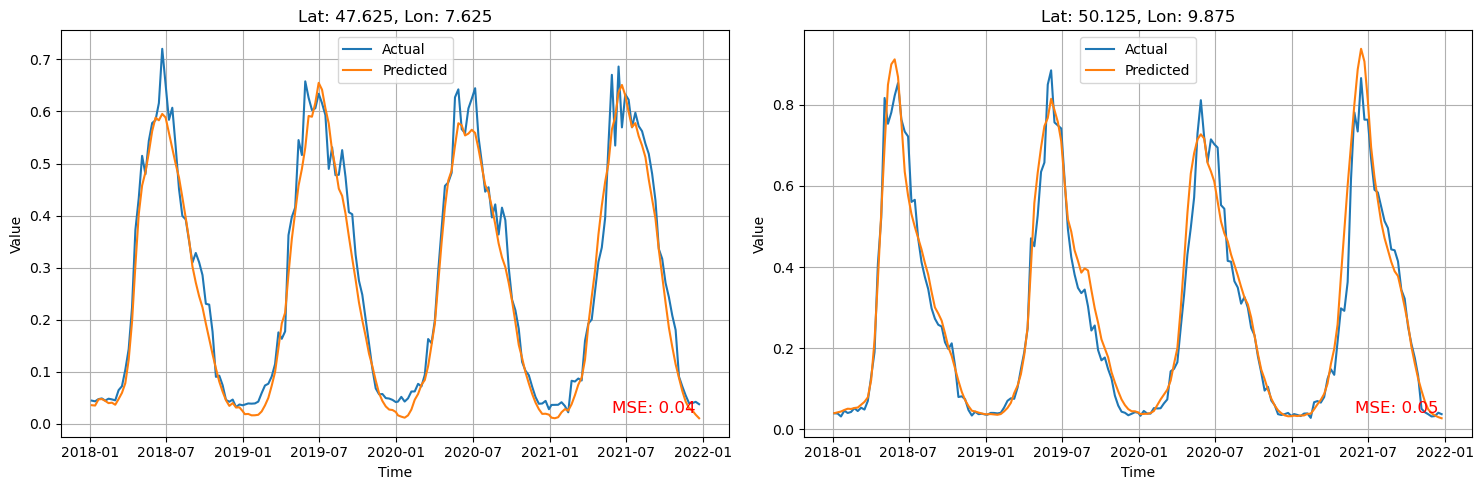

In [37]:
import matplotlib.pyplot as plt


# Function to plot predicted vs. actual values with MSE in subplots
def plot_multiple_results(results, evaluation, unique_pairs, look_back):
    num_plots = len(results)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            testY, forecasts = results[i]
            mae, mse = evaluation[i]
            lat, lon = unique_pairs.iloc[i]
            time_index = sorted(test_index)

            ax.plot(time_index[:-1], testY, label="Actual")
            ax.plot(time_index[:-1], forecasts, label="Predicted")
            ax.set_title(f"Lat: {lat}, Lon: {lon}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Value")
            ax.legend()
            ax.grid(True)
            # Add MSE to the corner
            ax.text(
                0.95,
                0.05,
                f"MSE: {mse:.2f}",
                verticalalignment="bottom",
                horizontalalignment="right",
                transform=ax.transAxes,
                color="red",
                fontsize=12,
            )

    plt.tight_layout()
    plt.show()


# Usage example:
# results is a list of tuples (testY, forecasts)
# evaluation is a list of tuples (mae, mse)
# unique_pairs is a DataFrame with columns 'lat' and 'lon'
plot_multiple_results(results_untuned, evaluation_untuned, unique_pairs, look_back)

# 3. Model multiple timeseries with with local model using hyperparameter Tuning

In [38]:
# Train the model
def run_model(
    trainX,
    trainY,
    valX,
    valY,
    look_back,
    epochs,
    learning_rate=0.001,
    batch_size=32,
    verbose=1,
):

    num_features = trainX.shape[2]
    model = improved_model_lstm(look_back, num_features, learning_rate)
    history = model.fit(
        trainX,
        trainY,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(valX, valY),
        callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
        verbose=verbose,
        shuffle=False,
    )
    return model, history

In [39]:
# Function to create a KerasRegressor for GridSearchCV
def create_keras_regressor(look_back, features):
    return KerasRegressor(
        model=create_model,
        look_back=look_back,
        features=features,
        dropout_rate=0.1,
        hidden_dim=64,
        hidden_dense=64,
        verbose=0,
    )


params = {
    #'learning_rate': [1e-3, 1e-4, 1e-5],
    "hidden_dim": [64, 128],
    "dropout_rate": [0.1, 0.3],
    "hidden_dense": [32, 64, 128],
    #'epochs': [50, 100, 150],
    #'batch_size': [16, 32, 64]
}

In [40]:
def create_model(
    look_back,
    features,
    learning_rate=0.001,
    hidden_dim=128,
    dropout_rate=0.1,
    hidden_dense=64
):
    """
    Creates and compiles an LSTM model.

    Parameters:
    look_back (int): Number of previous time steps to consider as input.
    features (int): Number of features in the input data.
    learning_rate (float): Learning rate for the optimizer.
    hidden_dim (int): Number of neurons in the LSTM layer.
    dropout_rate (float): Dropout rate for regularization.
    hidden_dense (int): Number of neurons in the dense layer following the LSTM layer.

    Returns:
    model (keras.Model): Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(hidden_dim, input_shape=(look_back, features), activation="relu"))
    model.add(Dropout(dropout_rate))

    model.add(Dense(hidden_dense, activation="relu"))
    model.add(Dense(1))  # Output layer; assumes a single target variable.

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        loss="mean_squared_error", optimizer=optimizer, metrics=["mse", "mae"]
    )


    return model

In [ ]:
print(2*"\n")
print(100*"-")
print(2*"\n")

print("Starting Modelling and GridsearchCV")


look_back = 40
batch_size = 32
epochs = 50
learning_rate = 0.0001
n_splits = 3
results = []
evaluation = []
histories = []
best_params = []

number = len(unique_pairs)
output_data = {}


for i in range(number):
    lat, lon = unique_pairs.iloc[i]
    trainX, trainY, valX, valY, testX, testY, test_index = split_data(
        all_data_scaled, lat, lon, look_back=look_back
    )

    # Create a KerasRegressor
    features = trainX.shape[2]
    model = create_keras_regressor(look_back, features)

    # Define GridSearchCV
    lstm_gs = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=TimeSeriesSplit(n_splits=n_splits),
        scoring="neg_mean_squared_error",
        verbose=1,
        n_jobs=-1,
    )

    # Perform grid search
    lstm_gs.fit(
        trainX,
        trainY,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
        shuffle=False,
    )

    # Get the best model from the grid search
    best_params = lstm_gs.best_params_

    model = create_model(
        look_back,
        features,
        learning_rate=learning_rate,
        hidden_dim=best_params["hidden_dim"],
        hidden_dense=best_params["hidden_dense"],
        dropout_rate=best_params["dropout_rate"],
    )

    history = model.fit(
        trainX,
        trainY,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(valX, valY),
        callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
        verbose=1,
        shuffle=False,
    )

    forecasts = predict_replace(model, testX)

    rmse = root_mean_squared_error(testY, forecasts)
    mae = mean_absolute_error(testY, forecasts)

    results.append([testY.tolist(), forecasts.tolist()])
    evaluation.append({"lat": lat, "lon": lon, "mae": mae, "rmse": rmse})

    histories.append(history.history)

    print(f"Completed {i + 1}/{len(unique_pairs)}")

    # Add results to the output dictionary
    output_data[(lat, lon)] = {
        "best_params": best_params,
        "evaluation": {"mae": mae, "rmse": rmse},
        "results": {"true_values": testY.tolist(), "predicted_values": forecasts.tolist()},
        "history": history.history,
    }

print(2*"\n")
print(100*"-")
print(2*"\n")






----------------------------------------------------------------------------------------------------



Starting Modelling and GridsearchCV
Fitting 3 folds for each of 12 candidates, totalling 36 fits


2024-07-11 10:30:43.504818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 10:30:43.504870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 10:30:43.504931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 10:30:43.504960: I tensorflow/core/platform/cpu_featu

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1152 - mae: 0.2555 - mse: 0.1152 - val_loss: 0.0869 - val_mae: 0.2181 - val_mse: 0.0869
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0793 - mae: 0.2008 - mse: 0.0793 - val_loss: 0.0515 - val_mae: 0.1748 - val_mse: 0.0515
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0484 - mae: 0.1701 - mse: 0.0484 - val_loss: 0.0287 - val_mae: 0.1441 - val_mse: 0.0287
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0309 - mae: 0.1507 - mse: 0.0309 - val_loss: 0.0205 - val_mae: 0.1242 - val_mse: 0.0205
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0245 - mae: 0.1351 - mse: 0.0245 - val_loss: 0.0144 - val_mae: 0.0987 - val_mse: 0.0144
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0182 - mae: 0.1096 - mse: 0.0182 - val_loss: 0.0104 - val_mae: 0.0809 - val_mse: 0.0104
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0130 - mae: 0.0914 - mse: 0.0130 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1279 - mae: 0.2503 - mse: 0.1279 - val_loss: 0.1119 - val_mae: 0.2314 - val_mse: 0.1119
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0905 - mae: 0.2011 - mse: 0.0905 - val_loss: 0.0825 - val_mae: 0.2089 - val_mse: 0.0825
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0694 - mae: 0.1868 - mse: 0.0694 - val_loss: 0.0639 - val_mae: 0.1942 - val_mse: 0.0639
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0547 - mae: 0.1786 - mse: 0.0547 - val_loss: 0.0528 - val_mae: 0.1818 - val_mse: 0.0528
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0484 - mae: 0.1742 - mse: 0.0484 - val_loss: 0.0451 - val_mae: 0.1680 - val_mse: 0.0451
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0420 - mae: 0.1594 - mse: 0.0420 - val_loss: 0.0388 - val_mae: 0.1516 - val_mse: 0.0388
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0373 - mae: 0.1466 - mse: 0.0373 - val_loss: 0.0332

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1630 - mae: 0.2945 - mse: 0.1630 - val_loss: 0.1192 - val_mae: 0.2538 - val_mse: 0.1192
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1069 - mae: 0.2379 - mse: 0.1069 - val_loss: 0.0787 - val_mae: 0.2246 - val_mse: 0.0787
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0744 - mae: 0.2188 - mse: 0.0744 - val_loss: 0.0570 - val_mae: 0.2065 - val_mse: 0.0570
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0554 - mae: 0.1998 - mse: 0.0554 - val_loss: 0.0413 - val_mae: 0.1743 - val_mse: 0.0413
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0417 - mae: 0.1696 - mse: 0.0417 - val_loss: 0.0282 - val_mae: 0.1329 - val_mse: 0.0282
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0315 - mae: 0.1367 - mse: 0.0315 - val_loss: 0.0205 - val_mae: 0.1045 - val_mse: 0.0205
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0251 - mae: 0.1167 - mse: 0.0251 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-07-11 10:45:21.289663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 10:45:21.290233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1044 - mae: 0.2318 - mse: 0.1044 - val_loss: 0.0804 - val_mae: 0.2031 - val_mse: 0.0804
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0600 - mae: 0.1733 - mse: 0.0600 - val_loss: 0.0451 - val_mae: 0.1648 - val_mse: 0.0451
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0351 - mae: 0.1526 - mse: 0.0351 - val_loss: 0.0286 - val_mae: 0.1428 - val_mse: 0.0286
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0254 - mae: 0.1398 - mse: 0.0254 - val_loss: 0.0201 - val_mae: 0.1180 - val_mse: 0.0201
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0185 - mae: 0.1161 - mse: 0.0185 - val_loss: 0.0141 - val_mae: 0.0909 - val_mse: 0.0141
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0129 - mae: 0.0902 - mse: 0.0129 - val_loss: 0.0103 - val_mae: 0.0724 - val_mse: 0.0103
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0098 - mae: 0.0744 - mse: 0.0098 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0953 - mae: 0.2207 - mse: 0.0953 - val_loss: 0.0701 - val_mae: 0.1884 - val_mse: 0.0701
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0555 - mae: 0.1661 - mse: 0.0555 - val_loss: 0.0442 - val_mae: 0.1667 - val_mse: 0.0442
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0377 - mae: 0.1548 - mse: 0.0377 - val_loss: 0.0342 - val_mae: 0.1549 - val_mse: 0.0342
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0314 - mae: 0.1483 - mse: 0.0314 - val_loss: 0.0277 - val_mae: 0.1357 - val_mse: 0.0277
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0259 - mae: 0.1296 - mse: 0.0259 - val_loss: 0.0225 - val_mae: 0.1157 - val_mse: 0.0225
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0212 - mae: 0.1100 - mse: 0.0212 - val_loss: 0.0184 - val_mae: 0.0998 - val_mse: 0.0184
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0165 - mae: 0.0925 - mse: 0.0165 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0541 - mae: 0.1599 - mse: 0.0541 - val_loss: 0.0328 - val_mae: 0.1474 - val_mse: 0.0328
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0278 - mae: 0.1399 - mse: 0.0278 - val_loss: 0.0225 - val_mae: 0.1285 - val_mse: 0.0225
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0214 - mae: 0.1243 - mse: 0.0214 - val_loss: 0.0164 - val_mae: 0.1022 - val_mse: 0.0164
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0163 - mae: 0.1008 - mse: 0.0163 - val_loss: 0.0125 - val_mae: 0.0843 - val_mse: 0.0125
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0125 - mae: 0.0830 - mse: 0.0125 - val_loss: 0.0098 - val_mae: 0.0699 - val_mse: 0.0098
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0094 - mae: 0.0696 - mse: 0.0094 - val_loss: 0.0077 - val_mae: 0.0621 - val_mse: 0.0077
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0085 - mae: 0.0650 - mse: 0.0085 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-07-11 10:59:57.699213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 10:59:57.701915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1299 - mae: 0.2626 - mse: 0.1299 - val_loss: 0.0983 - val_mae: 0.2311 - val_mse: 0.0983
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0769 - mae: 0.2050 - mse: 0.0769 - val_loss: 0.0592 - val_mae: 0.1983 - val_mse: 0.0592
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0504 - mae: 0.1889 - mse: 0.0504 - val_loss: 0.0421 - val_mae: 0.1806 - val_mse: 0.0421
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0414 - mae: 0.1816 - mse: 0.0414 - val_loss: 0.0336 - val_mae: 0.1626 - val_mse: 0.0336
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0320 - mae: 0.1595 - mse: 0.0320 - val_loss: 0.0254 - val_mae: 0.1361 - val_mse: 0.0254
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0239 - mae: 0.1328 - mse: 0.0239 - val_loss: 0.0180 - val_mae: 0.1089 - val_mse: 0.0180
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0185 - mae: 0.1080 - mse: 0.0185 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1649 - mae: 0.3091 - mse: 0.1649 - val_loss: 0.1217 - val_mae: 0.2469 - val_mse: 0.1217
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1076 - mae: 0.2262 - mse: 0.1076 - val_loss: 0.0776 - val_mae: 0.2019 - val_mse: 0.0776
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0708 - mae: 0.1944 - mse: 0.0708 - val_loss: 0.0540 - val_mae: 0.1845 - val_mse: 0.0540
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0525 - mae: 0.1846 - mse: 0.0525 - val_loss: 0.0426 - val_mae: 0.1761 - val_mse: 0.0426
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0422 - mae: 0.1702 - mse: 0.0422 - val_loss: 0.0328 - val_mae: 0.1531 - val_mse: 0.0328
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0332 - mae: 0.1504 - mse: 0.0332 - val_loss: 0.0245 - val_mae: 0.1266 - val_mse: 0.0245
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0272 - mae: 0.1275 - mse: 0.0272 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-07-11 11:09:45.567317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optim

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0338 - mae: 0.1300 - mse: 0.0338 - val_loss: 0.0257 - val_mae: 0.1266 - val_mse: 0.0257
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0197 - mae: 0.1125 - mse: 0.0197 - val_loss: 0.0154 - val_mae: 0.1002 - val_mse: 0.0154
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0128 - mae: 0.0934 - mse: 0.0128 - val_loss: 0.0109 - val_mae: 0.0767 - val_mse: 0.0109
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0098 - mae: 0.0751 - mse: 0.0098 - val_loss: 0.0085 - val_mae: 0.0646 - val_mse: 0.0085
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0079 - mae: 0.0646 - mse: 0.0079 - val_loss: 0.0065 - val_mae: 0.0559 - val_mse: 0.0065
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0062 - mae: 0.0591 - mse: 0.0062 - val_loss: 0.0049 - val_mae: 0.0472 - val_mse: 0.0049
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - mae: 0.0540 - mse: 0.0056 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-07-11 11:14:36.091700: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optim

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0641 - mae: 0.1744 - mse: 0.0641 - val_loss: 0.0471 - val_mae: 0.1656 - val_mse: 0.0471
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0396 - mae: 0.1520 - mse: 0.0396 - val_loss: 0.0305 - val_mae: 0.1445 - val_mse: 0.0305
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0276 - mae: 0.1362 - mse: 0.0276 - val_loss: 0.0216 - val_mae: 0.1237 - val_mse: 0.0216
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0203 - mae: 0.1159 - mse: 0.0203 - val_loss: 0.0147 - val_mae: 0.0969 - val_mse: 0.0147
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0140 - mae: 0.0922 - mse: 0.0140 - val_loss: 0.0101 - val_mae: 0.0754 - val_mse: 0.0101
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0106 - mae: 0.0768 - mse: 0.0106 - val_loss: 0.0074 - val_mae: 0.0628 - val_mse: 0.0074
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0082 - mae: 0.0657 - mse: 0.0082 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1048 - mae: 0.2294 - mse: 0.1048 - val_loss: 0.0806 - val_mae: 0.2198 - val_mse: 0.0806
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0665 - mae: 0.1989 - mse: 0.0665 - val_loss: 0.0485 - val_mae: 0.1841 - val_mse: 0.0485
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0432 - mae: 0.1774 - mse: 0.0432 - val_loss: 0.0299 - val_mae: 0.1519 - val_mse: 0.0299
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0305 - mae: 0.1539 - mse: 0.0305 - val_loss: 0.0199 - val_mae: 0.1215 - val_mse: 0.0199
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0221 - mae: 0.1263 - mse: 0.0221 - val_loss: 0.0139 - val_mae: 0.0940 - val_mse: 0.0139
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0162 - mae: 0.1012 - mse: 0.0162 - val_loss: 0.0101 - val_mae: 0.0754 - val_mse: 0.0101
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - mae: 0.0882 - mse: 0.0131 - val_loss: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-07-11 11:41:28.168120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1102 - mae: 0.2291 - mse: 0.1102 - val_loss: 0.0729 - val_mae: 0.2011 - val_mse: 0.0729
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0682 - mae: 0.1975 - mse: 0.0682 - val_loss: 0.0479 - val_mae: 0.1763 - val_mse: 0.0479
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0463 - mae: 0.1713 - mse: 0.0463 - val_loss: 0.0338 - val_mae: 0.1526 - val_mse: 0.0338
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0337 - mae: 0.1471 - mse: 0.0337 - val_loss: 0.0245 - val_mae: 0.1197 - val_mse: 0.0245
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0265 - mae: 0.1200 - mse: 0.0265 - val_loss: 0.0188 - val_mae: 0.0977 - val_mse: 0.0188
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0207 - mae: 0.1025 - mse: 0.0207 - val_loss: 0.0142 - val_mae: 0.0827 - val_mse: 0.0142
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0181 - mae: 0.0962 - mse: 0.0181 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0757 - mae: 0.2136 - mse: 0.0757 - val_loss: 0.0548 - val_mae: 0.1663 - val_mse: 0.0548
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0437 - mae: 0.1469 - mse: 0.0437 - val_loss: 0.0332 - val_mae: 0.1362 - val_mse: 0.0332
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0262 - mae: 0.1232 - mse: 0.0262 - val_loss: 0.0208 - val_mae: 0.1218 - val_mse: 0.0208
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0178 - mae: 0.1149 - mse: 0.0178 - val_loss: 0.0172 - val_mae: 0.1170 - val_mse: 0.0172
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0152 - mae: 0.1077 - mse: 0.0152 - val_loss: 0.0130 - val_mae: 0.0988 - val_mse: 0.0130
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0111 - mae: 0.0892 - mse: 0.0111 - val_loss: 0.0097 - val_mae: 0.0817 - val_mse: 0.0097
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0085 - mae: 0.0742 - mse: 0.0085 - val_loss: 

/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/imkeott/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `

# Writing Results and testing results

In [ ]:
import json
import numpy as np

# Convert the output data to a serializable format
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.generic):
        return obj.item()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    return obj

# Convert the data to a serializable format
output_data_serializable = convert_to_serializable(output_data)

# Writing data to 'model_results.txt'
with open("model_results.txt", "w") as file:
    file.write(json.dumps(output_data_serializable, indent=4))

print("Results and evaluation have been written to 'model_results.txt'")


In [46]:
import json

# Reading the results and evaluation from the file
with open('model_results.txt', 'r') as file:
    loaded_data = json.load(file)

# Extracting the loaded data
best_params = loaded_data['best_params']
evaluation = loaded_data['evaluation']
results = loaded_data['results']
histories = loaded_data['histories']

# Printing the loaded data to verify
print("Best Params:", best_params)
print("Evaluation:", evaluation)
print("Results:", results)
print("Histories:", histories)


Best Params: {'dropout_rate': 0.1, 'hidden_dense': 128, 'hidden_dim': 128}
Evaluation: [{'lat': 47.625, 'lon': 7.625, 'mae': 0.029320450499653816, 'rmse': 0.043738264590501785}, {'lat': 50.125, 'lon': 9.875, 'mae': 0.03902357816696167, 'rmse': 0.05835363641381264}]
Results: [[[0.044758837670087814, 0.043399251997470856, 0.047653015702962875, 0.048999153077602386, 0.04479249566793442, 0.04845396801829338, 0.047148220241069794, 0.04530402272939682, 0.06489022076129913, 0.0724823996424675, 0.1041097342967987, 0.1436927169561386, 0.2235518991947174, 0.372353196144104, 0.43327900767326355, 0.5147468447685242, 0.4795859158039093, 0.5436012148857117, 0.5778265595436096, 0.5831639170646667, 0.6159893274307251, 0.7202606201171875, 0.6510089039802551, 0.5838639736175537, 0.6071451902389526, 0.5327041745185852, 0.45100757479667664, 0.3994036614894867, 0.3926326036453247, 0.35054585337638855, 0.3098321557044983, 0.3282606601715088, 0.3102830648422241, 0.28579023480415344, 0.23072002828121185, 0.22

In [ ]:
mean_squared_error(testY, forecasts)

In [ ]:
best_params

In [ ]:
mae

In [ ]:
evaluation

In [ ]:
evaluation

In [ ]:
plot_multiple_results(results, evaluation, unique_pairs, look_back)

In [ ]:
plot_training(history)